In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('ab_data_cummulative.csv')

In [3]:
df.head()

,Unnamed: 0,user_id,timestamp,group,converted
0,0,851104,2017-01-21,A,0
1,1,804228,2017-01-12,A,0
2,2,661590,2017-01-11,B,0
3,3,853541,2017-01-08,B,0
4,4,864975,2017-01-21,A,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  294478 non-null  int64 
 1   user_id     294478 non-null  int64 
 2   timestamp   294478 non-null  object
 3   group       294478 non-null  object
 4   converted   294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Пропущенные значения отсутствуют, но столбец timestamp воспринимается Pandas как object. Необходимо перевести его в тип данных, соответствующий дате:

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (в веб-аналитике это называется «сессии») и его действия. Чтобы посчитать конверсию по каждому дню, необходимо сделать таблицу, которую мы сгруппируем по дате и группе, и посчитать количество пользователей, заходивших на сайт, и количество целевых действий:

In [6]:
df_piv = df.groupby(['timestamp','group']).agg({'user_id':'count','converted':'sum'}).reset_index()
df_piv.head()

,timestamp,group,user_id,converted
0,2017-01-02,A,2895,365
1,2017-01-02,B,2888,345
2,2017-01-03,A,6682,759
3,2017-01-03,B,6712,763
4,2017-01-04,A,6666,812


Посчитаем конверсию в целевое действие:

In [7]:
df_piv['conversion'] = df_piv['converted'] / df_piv['user_id']
df_piv.head()

,timestamp,group,user_id,converted,conversion
0,2017-01-02,A,2895,365,0.126079
1,2017-01-02,B,2888,345,0.119460
2,2017-01-03,A,6682,759,0.113589
3,2017-01-03,B,6712,763,0.113677
4,2017-01-04,A,6666,812,0.121812


Для облегчения восприятия кода создадим два отдельных датафрейма из полученной выше таблицы.

In [8]:
df_a = df_piv[df_piv['group'] == 'A']
df_b = df_piv[df_piv['group'] == 'B']

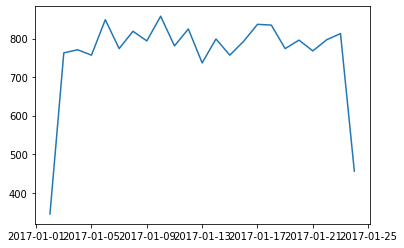

In [9]:
# Тренировка :)
plt.plot(df_b['timestamp'], df_b['converted'])
plt.show()

 зададим целых два метода plt.plot():

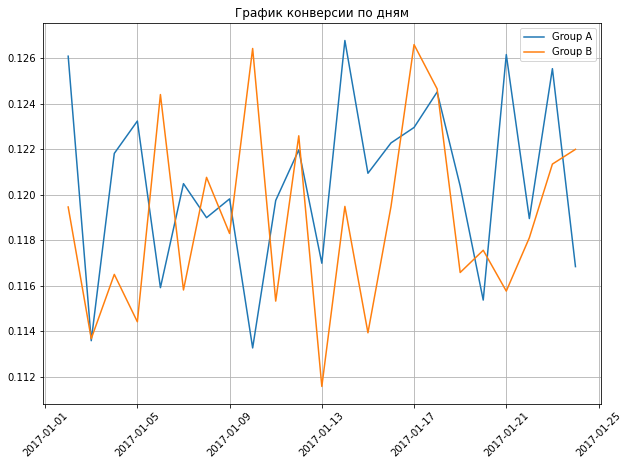

In [10]:
plt.figure(figsize=(10,7)) # Задаём размер графика
plt.plot(df_a['timestamp'], df_a['conversion'], label='Group A') # label — подпись данных на графике
plt.plot(df_b['timestamp'], df_b['conversion'], label='Group B')
plt.title('График конверсии по дням') # Название графика
plt.xticks(rotation = 45) # Разворот названия дат на оси X на 45 градусов
plt.legend() # Выводим название, указанное в label в plt.plot() на график
plt.grid(True) # Выводим сетку на график
plt.show() # Выводим график на экран


Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — тоже затруднительно. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Напишем функцию, которая для каждой уникальной даты в столбце timestamp отфильтрует строки таблицы, где значения даты меньше или равны этой уникальной дате, и посчитает сумму значений в столбец user_id и в столбце converted.

In [11]:
def cummulative_table(data): # В переменную data будем передавать название переменной датафейма
    df_cumm = [] # Создаём пустой список
    for i in data['timestamp'].values: # Запускаем цикл по каждому отдельному значению даты
        out = data[data['timestamp'] <= i].groupby('group').agg({'timestamp':'max', 'user_id':'sum', 'converted':'sum'})
        df_cumm.append(out) # Полученный срез добавляем в созданный ранее список
    return pd.concat(df_cumm).reset_index() # Объединяем списки и возвращаем результат

Применим написанную функцию к таблицам df_a и df_b:

In [12]:
cumm_a = cummulative_table(df_a)
cumm_b = cummulative_table(df_b)

In [13]:
cumm_a.head()

,group,timestamp,user_id,converted
0,A,2017-01-02,2895,365
1,A,2017-01-03,9577,1124
2,A,2017-01-04,16243,1936
3,A,2017-01-05,22751,2738
4,A,2017-01-06,29454,3515


В обеих кумулятивных таблицах рассчитаем конверсию.

In [14]:
cumm_a['conversion'] = cumm_a['converted'] / cumm_a['user_id']
cumm_b['conversion'] = cumm_b['converted'] / cumm_b['user_id']

И выведем на графике кумулятивную конверсию обеих групп.

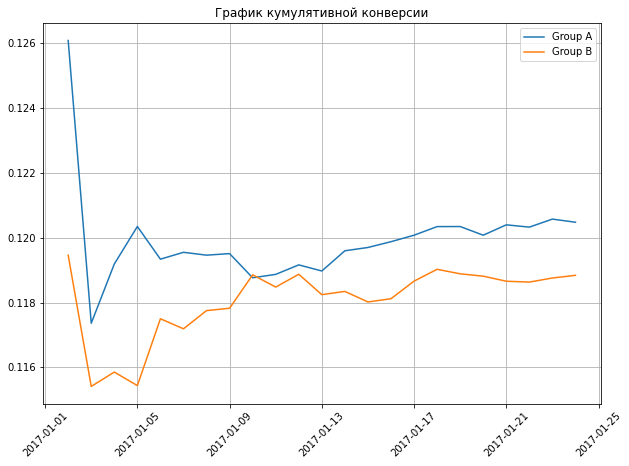

In [15]:
plt.figure(figsize=(10,7))
plt.plot(cumm_a['timestamp'], cumm_a['conversion'], label='Group A')
plt.plot(cumm_b['timestamp'], cumm_b['conversion'], label='Group B')
plt.title('График кумулятивной конверсии')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()

***

In [16]:
dfa = pd.read_csv('ab_test-redesign_sample_a.csv', dtype={'cid': str})

dfb = pd.read_csv('ab_test-redesign_sample_b.csv', dtype={'cid': str})

In [17]:
dfa.info()
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61571 entries, 0 to 61570
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          61571 non-null  object
 1   cid           61571 non-null  object
 2   users         61571 non-null  int64 
 3   transactions  61571 non-null  int64 
 4   revenue       61571 non-null  int64 
 5   group         61571 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61383 entries, 0 to 61382
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          61383 non-null  object
 1   cid           61383 non-null  object
 2   users         61383 non-null  int64 
 3   transactions  61383 non-null  int64 
 4   revenue       61383 non-null  int64 
 5   group         61383 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.8+ MB


Приводим data к datetime64

In [18]:
dfa['date'] = pd.to_datetime(dfa['date'], format='%Y-%m-%d')
dfb['date'] = pd.to_datetime(dfb['date'], format='%Y-%m-%d')

In [19]:
dfa.head()

,date,cid,users,transactions,revenue,group
0,2020-11-06,1001647767.1604671021,1,0,0,A
1,2020-11-06,1001936214.1604661908,1,0,0,A
2,2020-11-06,100321440.1603903817,1,0,0,A
3,2020-11-06,1004392551.1603713590,1,0,0,A
4,2020-11-06,1006382383.1604681479,1,0,0,A


In [20]:
dfa_piv = dfa.groupby(['date','group']).agg({'users':'sum', 'transactions':'sum', 'revenue':'sum'}).reset_index()
dfb_piv = dfb.groupby(['date','group']).agg({'users':'sum', 'transactions':'sum', 'revenue':'sum'}).reset_index()

In [21]:
def cummulative_table(data): # В переменную data будем передавать название переменной датафейма
    df_cumm = [] # Создаём пустой список
    for i in data['date'].values: # Запускаем цикл по каждому отдельному значению даты
        out = data[data['date'] <= i].groupby('group')\
               .agg({'date':'max', 'users':'sum', 'transactions':'sum'})
        df_cumm.append(out) # Полученный срез добавляем в созданный ранее список
    return pd.concat(df_cumm).reset_index() # Объединяем списки и возвращаем результат

In [22]:
cumm_a = cummulative_table(dfa_piv)
cumm_b = cummulative_table(dfb_piv)

In [23]:
cumm_a['conversion'] = cumm_a['transactions'] / cumm_a['users']
cumm_b['conversion'] = cumm_b['transactions'] / cumm_b['users']

Выведите график кумулятивной конверсии, заполнив пропуски в коде.

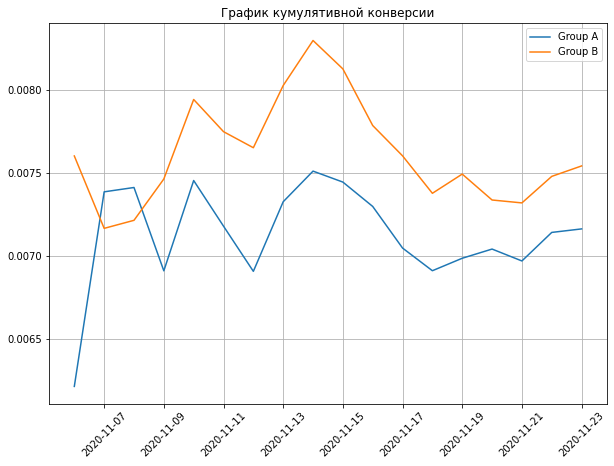

In [24]:
plt.figure(figsize=(10,7))
plt.plot(cumm_a['date'], cumm_a['conversion'], label='Group A')
plt.plot(cumm_b['date'], cumm_b['conversion'], label='Group B')
plt.title('График кумулятивной конверсии')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()